In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import math
import random
from sklearn import preprocessing

In [2]:
data = pd.read_csv('Perth_100y_features.csv',header=0)

In [3]:
data

,date,month,mon_rain_sum,max_temp_mean,min_temp_mean,radiation_mean,rh_tmax_mean,rh_tmin_mean,SOI,NINO 12,NINO 3,NINO 3.4,NINO 4,DMI,PDO
0,1921/1/1,1,1.1,30.167742,17.777419,25.496774,38.280645,77.458065,10.8,-0.442339,0.303360,0.490091,-0.057400,-0.119109,-0.66
1,1921/2/1,2,39.4,33.700000,21.142857,22.689286,35.200000,71.864286,6.7,-0.510237,-0.229834,-0.499174,-0.510563,0.010900,-0.61
2,1921/3/1,3,24.2,30.274194,17.906452,20.706452,38.916129,79.503226,8.9,-0.558844,-1.094380,-1.372060,-0.943420,0.079200,-0.01
3,1921/4/1,4,21.1,24.576667,13.926667,15.276667,48.290000,89.543333,-7.1,-0.939302,-0.593195,-0.481306,-0.259726,0.001330,-0.93
4,1921/5/1,5,268.2,20.609677,13.203226,9.445161,60.870968,94.516129,2.1,-0.750797,-0.841282,-0.841772,-0.678158,0.164967,-0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2020/8/1,8,75.1,18.809677,8.935484,12.167742,53.122581,93.261290,9.8,-0.536390,-0.428913,-0.341616,0.092700,0.110595,-0.28
1196,2020/9/1,9,73.7,21.240000,11.123333,15.390000,49.263333,87.996667,10.5,-0.970116,-0.822868,-0.607735,-0.076900,0.185042,-0.70
1197,2020/10/1,10,14.3,24.729032,12.777419,23.061290,40.812903,82.400000,4.2,-1.037680,-1.005360,-1.148310,-0.499672,0.437923,-0.69
1198,2020/11/1,11,84.7,24.276667,13.570000,21.520000,46.493333,86.453333,9.2,-0.890734,-0.898487,-0.960775,-0.335106,0.276562,-1.12


In [4]:
global data_np 
data_np = data.to_numpy()[:,2:]

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
data_np_scale = min_max_scaler.fit_transform(data_np)
original_rain_data = data_np[:,0]
global max_rain
max_rain = np.max(original_rain_data)
rain_data = data_np_scale[:,0]

In [6]:
"Optimal parameters"
global feat_num,use_len
feat_num = data_np.shape[1]
use_len = 12
pred_len = 12
hidden_dim = 128
batch_size = 64

In [7]:
def create_index_set(rain_data,data_np,use_len,pred_len): 
    
    sample_size = len(rain_data)-(use_len + pred_len - 1)
    
    X_sample = np.zeros((sample_size,use_len,data_np.shape[1]))
    Y_sample = np.zeros((sample_size,pred_len))
    
    for i in range(use_len,len(rain_data)-pred_len+1):  
        Y_sample[i-use_len]= rain_data[i:i+pred_len]
        X_sample[i-use_len]= data_np[i-use_len:i,:]
            
    X_sample = X_sample.reshape(len(X_sample),use_len,data_np.shape[1])
    Y_sample = Y_sample.reshape(len(Y_sample),pred_len,1)

    return X_sample,Y_sample

In [8]:
X_sample,Y_sample = create_index_set(original_rain_data,data_np_scale,use_len,pred_len)

In [9]:
X_sample.shape

(1177, 12, 13)

In [10]:
X_tr,X_1fold,Y_tr,Y_1fold = train_test_split(X_sample,Y_sample,test_size=392,shuffle = True)
X_2fold,X_3fold,Y_2fold,Y_3fold = train_test_split(X_tr,Y_tr,test_size=392,shuffle = True)

X1fold_tensor=torch.from_numpy(X_1fold)
Y1fold_tensor=torch.from_numpy(Y_1fold)

X2fold_tensor=torch.from_numpy(X_2fold)
Y2fold_tensor=torch.from_numpy(Y_2fold)

X3fold_tensor=torch.from_numpy(X_3fold)
Y3fold_tensor=torch.from_numpy(Y_3fold)

In [11]:
class RainTrainDataset(Dataset):
    
    def __init__(self,X_train,Y_train):

        self.input = torch.from_numpy(X_train) 
        self.output = torch.from_numpy(Y_train)  
    
    def __getitem__(self, index):
        return self.input[index], self.output[index]

    def __len__(self):
        return len(self.input)
    
class encoder_gru(nn.Module):
    
    def __init__(self, input_size, hidden_size,num_layers):
        
        super(encoder_gru, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
        self.gru = torch.nn.GRU(input_size = self.input_size,hidden_size = self.hidden_size,\
                                num_layers=self.num_layers,batch_first=True)
        
    def forward(self, input):
        
        self.batch_size = input.shape[0]
        hidden_0 = torch.zeros(self.num_layers,self.batch_size,self.hidden_size)
        output1, hidden1 = self.gru(input, hidden_0)
        
        return output1 

class Attention(nn.Module):
    
    def __init__(self, hidden_size):
        
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        
        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)

    def forward(self, hidden, encoder_outputs):

        this_batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len,1,1).transpose(0,1)    
        attn_energies = self.score(H,encoder_outputs) # compute attention score
        return F.softmax(attn_energies,dim = 1).unsqueeze(1)  # normalize with softmax

    def score(self, hidden, encoder_outputs):
        
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2))) 
        energy = energy.transpose(2,1) 
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) 
        energy = torch.bmm(v,energy) 
        
        return energy.squeeze(1)

class decoder_gru_cell(nn.Module):
    
    def __init__(self, hidden_size, output_size, n_layers):
        
        super(decoder_gru_cell, self).__init__()
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Define layers
        
        self.attn = Attention(hidden_size = self.hidden_size)
        self.gru = nn.GRU(hidden_size+1, hidden_size, n_layers, batch_first= True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, current_input, last_hidden, encoder_outputs):
        
        # Calculate attention weights and apply to encoder outputs
        
        current_input = current_input.unsqueeze(0)   
        attn_weights = self.attn(last_hidden, encoder_outputs)  
        context = attn_weights.bmm(encoder_outputs)  
        context = context.transpose(0, 1)  
        rnn_input = torch.cat((current_input, context), 2)   
        rnn_input = rnn_input.transpose(0,1)        
        output, hidden = self.gru(rnn_input, last_hidden)    
        output = output.squeeze(1) 
        output = torch.relu(self.out(output)) 
        
        return output,hidden

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder_cell,pre_len,hidden_size, decoder_layers):
        
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.pre_len = pre_len
        self.hidden_size = hidden_size   
        self.decoder_layers = decoder_layers 
        
    def forward(self,input):
        
        batch_size = input.size(0)
        use_len = input.size(1)
        feat_num = input.size(2)
        encoder_outputs = self.encoder(input)
        
        outputs = torch.zeros(self.pre_len,batch_size,1)
        
        current_input = input[:,-1,-1].reshape(batch_size,1)  # current_input: [B,1]
        last_hidden = torch.zeros(self.decoder_layers,batch_size,self.hidden_size)
        
        for i in range(self.pre_len):
        
            output,hidden = self.decoder_cell(current_input, last_hidden, encoder_outputs)
            current_input = output
            last_hidden = hidden
            outputs[i] = output
            
        outputs = outputs.transpose(0,1) #outputs:(B,pre_len,1)
        outputs = outputs*max_rain
        
        return outputs

In [12]:
def evaluate_model(set_tensor,tar_tensor,model,criterion):
    model.eval()
    output = model(set_tensor.float())
    res_output = output.reshape(-1,1)
    target=tar_tensor.reshape(-1,1)   
    MSE = criterion(res_output, target)
    R2= r2_score(target.numpy(),res_output.numpy())
    return tar_tensor.numpy(),output.numpy(),MSE.item(),R2

Train the 1st fold,X_1fold serves as the test set

In [13]:
encoder_1 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1)
decoder_cell_1 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1)
Seq2Seq_model_1 = Seq2Seq(encoder_1, decoder_cell_1,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1)

X_train_1  = np.concatenate((X_2fold,X_3fold),axis = 0)
Y_train_1 = np.concatenate((Y_2fold,Y_3fold),axis = 0)
X_train_1_tensor = torch.from_numpy(X_train_1)
Y_train_1_tensor = torch.from_numpy(Y_train_1)

trainset_1 = RainTrainDataset(X_train_1, Y_train_1)
trainloader_1 = DataLoader(trainset_1, batch_size=batch_size, shuffle=True)
criterion_1 = torch.nn.MSELoss() 
optimizer_1 = torch.optim.Adam(Seq2Seq_model_1.parameters(), lr=0.001,weight_decay =0)
scheduler_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_1,T_max = 32,eta_min = 0, last_epoch=-1)

 1 epoch ... 
best test R2 at this time -0.05749058477042479
 2 epoch ... 
best test R2 at this time -0.022878764627183967
 3 epoch ... 
best test R2 at this time -0.018430825105144155
 4 epoch ... 
best test R2 at this time -0.009702533028870697
 5 epoch ... 
best test R2 at this time 0.0026101406893564993
 6 epoch ... 
best test R2 at this time 0.003983891230004533
 7 epoch ... 
best test R2 at this time 0.004452752651139202
 8 epoch ... 
best test R2 at this time 0.004851274945920192
 9 epoch ... 
 10 epoch ... 
best test R2 at this time 0.008013737107258834
 11 epoch ... 
best test R2 at this time 0.01346244867791635
 12 epoch ... 
best test R2 at this time 0.016997604174991632
 13 epoch ... 
best test R2 at this time 0.017623888266128818
 14 epoch ... 
best test R2 at this time 0.0316695008375828
 15 epoch ... 
best test R2 at this time 0.15636864320078125
 16 epoch ... 
best test R2 at this time 0.20392036332126728
 17 epoch ... 
best test R2 at this time 0.2437207084896088
 18 e

 322 epoch ... 
 323 epoch ... 
 324 epoch ... 
 325 epoch ... 
 326 epoch ... 
 327 epoch ... 
 328 epoch ... 
best test R2 at this time 0.7047015871790232
 329 epoch ... 
 330 epoch ... 
 331 epoch ... 
 332 epoch ... 
 333 epoch ... 
 334 epoch ... 
 335 epoch ... 
 336 epoch ... 
 337 epoch ... 
best test R2 at this time 0.7062081344843474
 338 epoch ... 
 339 epoch ... 
 340 epoch ... 
 341 epoch ... 
 342 epoch ... 
best test R2 at this time 0.7068388533192047
 343 epoch ... 
best test R2 at this time 0.7072481739985845
 344 epoch ... 
 345 epoch ... 
 346 epoch ... 
 347 epoch ... 
 348 epoch ... 
best test R2 at this time 0.7076133210896038
 349 epoch ... 
 350 epoch ... 
 351 epoch ... 
 352 epoch ... 
 353 epoch ... 
 354 epoch ... 
 355 epoch ... 
 356 epoch ... 
 357 epoch ... 
best test R2 at this time 0.7077308282979828
 358 epoch ... 
 359 epoch ... 
 360 epoch ... 
 361 epoch ... 
 362 epoch ... 
 363 epoch ... 
 364 epoch ... 
 365 epoch ... 
 366 epoch ... 
 367 epoch

best test R2 at this time 0.7602099578009117
 703 epoch ... 
 704 epoch ... 
 705 epoch ... 
 706 epoch ... 
 707 epoch ... 
best test R2 at this time 0.7626979681574041
 708 epoch ... 
 709 epoch ... 
 710 epoch ... 
 711 epoch ... 
 712 epoch ... 
 713 epoch ... 
 714 epoch ... 
 715 epoch ... 
 716 epoch ... 
best test R2 at this time 0.7649431162298426
 717 epoch ... 
best test R2 at this time 0.7650564357742239
 718 epoch ... 
 719 epoch ... 
 720 epoch ... 
 721 epoch ... 
best test R2 at this time 0.765815153284961
 722 epoch ... 
 723 epoch ... 
 724 epoch ... 
 725 epoch ... 
 726 epoch ... 
 727 epoch ... 
best test R2 at this time 0.7664195951855248
 728 epoch ... 
 729 epoch ... 
 730 epoch ... 
 731 epoch ... 
best test R2 at this time 0.768759850706981
 732 epoch ... 
best test R2 at this time 0.7688549202577166
 733 epoch ... 
 734 epoch ... 
 735 epoch ... 
 736 epoch ... 
 737 epoch ... 
 738 epoch ... 
 739 epoch ... 
 740 epoch ... 
 741 epoch ... 
 742 epoch ... 
be

 1140 epoch ... 
 1141 epoch ... 
 1142 epoch ... 
 1143 epoch ... 
 1144 epoch ... 
 1145 epoch ... 
 1146 epoch ... 
 1147 epoch ... 
 1148 epoch ... 
 1149 epoch ... 
 1150 epoch ... 
 1151 epoch ... 
 1152 epoch ... 
 1153 epoch ... 
 1154 epoch ... 
 1155 epoch ... 
 1156 epoch ... 
 1157 epoch ... 
 1158 epoch ... 
 1159 epoch ... 
 1160 epoch ... 
 1161 epoch ... 
 1162 epoch ... 
 1163 epoch ... 
 1164 epoch ... 
 1165 epoch ... 
 1166 epoch ... 
 1167 epoch ... 
 1168 epoch ... 
 1169 epoch ... 
 1170 epoch ... 
 1171 epoch ... 
 1172 epoch ... 
 1173 epoch ... 
 1174 epoch ... 
 1175 epoch ... 
 1176 epoch ... 
 1177 epoch ... 
 1178 epoch ... 
 1179 epoch ... 
 1180 epoch ... 
 1181 epoch ... 
 1182 epoch ... 
 1183 epoch ... 
 1184 epoch ... 
 1185 epoch ... 
 1186 epoch ... 
 1187 epoch ... 
 1188 epoch ... 
 1189 epoch ... 
 1190 epoch ... 
 1191 epoch ... 
 1192 epoch ... 
 1193 epoch ... 
 1194 epoch ... 
 1195 epoch ... 
 1196 epoch ... 
 1197 epoch ... 
 1198 epoch ..

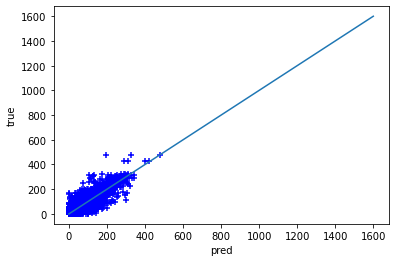

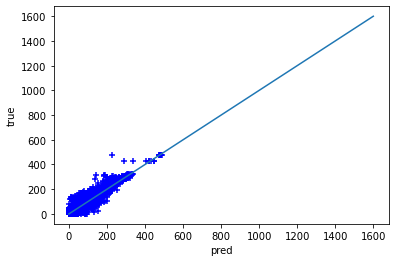

In [14]:

N_EPOCHS_1 = 1200

train_MSEloss_1=[]
test_MSEloss_1=[]

best_test_loss_1 = 1000000

for epoch in range(1, N_EPOCHS_1+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_1.train()
    for i, (hist, target) in enumerate(trainloader_1, 1):   
        hist = hist.float()
        output = Seq2Seq_model_1(hist)
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1)
        loss = criterion_1(output, target)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()
        scheduler_1.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_1_tensor,Y_train_1_tensor,Seq2Seq_model_1,criterion_1)
        train_MSEloss_1.append(train_MSE)
      
        _,_,test_MSE,test_R2 = evaluate_model(X1fold_tensor,Y1fold_tensor,Seq2Seq_model_1,criterion_1)
        test_MSEloss_1.append(test_MSE)

        if test_MSE < best_test_loss_1:
            best_test_loss_1 = test_MSE
            torch.save(Seq2Seq_model_1.state_dict(),'Prediction\best_model_1fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_1fold = Seq2Seq(encoder_1, decoder_cell_1,pre_len=12,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_1fold.load_state_dict(torch.load('Prediction\best_model_1fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_1fold,test_pred_1fold,test_MSE_1fold,test_R2_1fold = evaluate_model(X1fold_tensor,Y1fold_tensor,\
                                                                                  best_Seq2Seq_model_1fold,criterion_1)
    
    print(f'Test 1 fold MSE: {test_MSE_1fold}')
    print(f'Test 1 fold R2: {test_R2_1fold}')
    plt.figure(3)
    plt.scatter(test_pred_1fold,test_true_1fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_1fold,train_pred_1fold,train_MSE_1fold,train_R2_1fold = evaluate_model(X_train_1_tensor,Y_train_1_tensor,\
                                                                                      best_Seq2Seq_model_1fold,criterion_1)
    
    print(f'train 1 fold MSE: {train_MSE_1fold}')
    print(f'train 1 fold R2: {train_R2_1fold}')
    plt.figure(5)
    plt.scatter(train_pred_1fold,train_true_1fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [15]:
SHAP_VALUE = np.zeros([pred_len,len(X_sample),use_len,feat_num])

In [16]:
import shap

allset_tensor = torch.from_numpy(X_sample)
background = allset_tensor.float()

e_1 = shap.GradientExplainer(best_Seq2Seq_model_1fold,background)
shap_values_1fold = e_1.shap_values(X1fold_tensor.float())
shap_values_1fold = np.array(shap_values_1fold)  

np.save('Explanation\shap_values_1fold.npy',shap_values_1fold)

# scale the shap values
for i in range(shap_values_1fold.shape[0]):   
    for j in range(shap_values_1fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_1fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_1fold[i,j]

Train the 2nd fold,X_2fold serves as the test set

In [19]:
encoder_2 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1)
decoder_cell_2 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1)
Seq2Seq_model_2 = Seq2Seq(encoder_2, decoder_cell_2,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1)

X_train_2  = np.concatenate((X_1fold,X_3fold),axis = 0)
Y_train_2 = np.concatenate((Y_1fold,Y_3fold),axis = 0)
X_train_2_tensor = torch.from_numpy(X_train_2)
Y_train_2_tensor = torch.from_numpy(Y_train_2)

trainset_2 = RainTrainDataset(X_train_2, Y_train_2)
trainloader_2 = DataLoader(trainset_2, batch_size=batch_size, shuffle=True)
criterion_2 = torch.nn.MSELoss()  
optimizer_2 = torch.optim.Adam(Seq2Seq_model_2.parameters(), lr=0.001,weight_decay =0) 
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_2,T_max = 32,eta_min = 0, last_epoch=-1)

 1 epoch ... 
best test R2 at this time -0.0007020560321022717
 2 epoch ... 
 3 epoch ... 
 4 epoch ... 
best test R2 at this time 0.0008581925604561613
 5 epoch ... 
best test R2 at this time 0.0056463645246107586
 6 epoch ... 
best test R2 at this time 0.005758408422118277
 7 epoch ... 
 8 epoch ... 
best test R2 at this time 0.01996146159489054
 9 epoch ... 
best test R2 at this time 0.04522155239348358
 10 epoch ... 
best test R2 at this time 0.170836403975693
 11 epoch ... 
 12 epoch ... 
best test R2 at this time 0.19024963091806146
 13 epoch ... 
best test R2 at this time 0.23070284684290732
 14 epoch ... 
best test R2 at this time 0.28337128960426106
 15 epoch ... 
best test R2 at this time 0.3197182733488052
 16 epoch ... 
best test R2 at this time 0.3298961987414011
 17 epoch ... 
best test R2 at this time 0.4689982221410661
 18 epoch ... 
best test R2 at this time 0.567129120913296
 19 epoch ... 
best test R2 at this time 0.5912227094511855
 20 epoch ... 
best test R2 at thi

 332 epoch ... 
 333 epoch ... 
 334 epoch ... 
 335 epoch ... 
 336 epoch ... 
 337 epoch ... 
 338 epoch ... 
 339 epoch ... 
 340 epoch ... 
 341 epoch ... 
 342 epoch ... 
 343 epoch ... 
 344 epoch ... 
 345 epoch ... 
 346 epoch ... 
 347 epoch ... 
 348 epoch ... 
 349 epoch ... 
 350 epoch ... 
best test R2 at this time 0.7011551465794224
 351 epoch ... 
 352 epoch ... 
 353 epoch ... 
 354 epoch ... 
best test R2 at this time 0.7012081220247137
 355 epoch ... 
best test R2 at this time 0.7027834729890754
 356 epoch ... 
 357 epoch ... 
 358 epoch ... 
 359 epoch ... 
 360 epoch ... 
 361 epoch ... 
 362 epoch ... 
 363 epoch ... 
 364 epoch ... 
 365 epoch ... 
best test R2 at this time 0.7033457781382605
 366 epoch ... 
 367 epoch ... 
 368 epoch ... 
 369 epoch ... 
 370 epoch ... 
 371 epoch ... 
 372 epoch ... 
 373 epoch ... 
 374 epoch ... 
 375 epoch ... 
 376 epoch ... 
best test R2 at this time 0.7034238859706257
 377 epoch ... 
 378 epoch ... 
 379 epoch ... 
 380 ep

 687 epoch ... 
 688 epoch ... 
 689 epoch ... 
 690 epoch ... 
 691 epoch ... 
 692 epoch ... 
 693 epoch ... 
 694 epoch ... 
 695 epoch ... 
 696 epoch ... 
 697 epoch ... 
 698 epoch ... 
 699 epoch ... 
 700 epoch ... 
 701 epoch ... 
 702 epoch ... 
 703 epoch ... 
best test R2 at this time 0.7959453506087767
 704 epoch ... 
 705 epoch ... 
best test R2 at this time 0.7963529470087599
 706 epoch ... 
 707 epoch ... 
 708 epoch ... 
 709 epoch ... 
 710 epoch ... 
 711 epoch ... 
 712 epoch ... 
 713 epoch ... 
 714 epoch ... 
 715 epoch ... 
 716 epoch ... 
 717 epoch ... 
 718 epoch ... 
 719 epoch ... 
 720 epoch ... 
 721 epoch ... 
 722 epoch ... 
 723 epoch ... 
 724 epoch ... 
 725 epoch ... 
 726 epoch ... 
 727 epoch ... 
 728 epoch ... 
 729 epoch ... 
 730 epoch ... 
 731 epoch ... 
 732 epoch ... 
 733 epoch ... 
 734 epoch ... 
best test R2 at this time 0.7975314691320052
 735 epoch ... 
best test R2 at this time 0.7982599945210165
 736 epoch ... 
 737 epoch ... 
 738

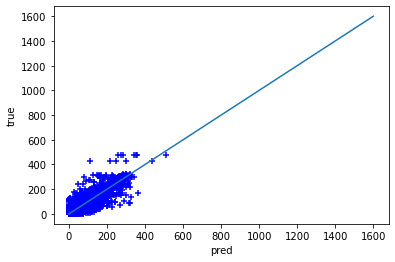

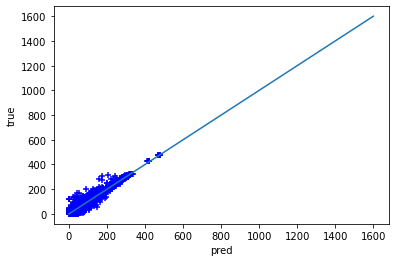

In [21]:

N_EPOCHS_2 = 1000

train_MSEloss_2=[]
test_MSEloss_2=[]

best_test_loss_2 = 1000000

for epoch in range(1, N_EPOCHS_2+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_2.train()
    for i, (hist, target) in enumerate(trainloader_2, 1):   
        hist = hist.float()
        output = Seq2Seq_model_2(hist) 
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1)
        loss = criterion_2(output, target)
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()
        scheduler_2.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_2_tensor,Y_train_2_tensor,Seq2Seq_model_2,criterion_2)
        train_MSEloss_2.append(train_MSE)
        
        _,_,test_MSE,test_R2 = evaluate_model(X2fold_tensor,Y2fold_tensor,Seq2Seq_model_2,criterion_2)
        test_MSEloss_2.append(test_MSE)

        if test_MSE < best_test_loss_2:
            best_test_loss_2 = test_MSE
            torch.save(Seq2Seq_model_2.state_dict(),'Prediction\best_model_2fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_2fold = Seq2Seq(encoder_2, decoder_cell_2,pre_len=12,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_2fold.load_state_dict(torch.load('Prediction\best_model_2fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_2fold,test_pred_2fold,test_MSE_2fold,test_R2_2fold = evaluate_model(X2fold_tensor,Y2fold_tensor,\
                                                                                  best_Seq2Seq_model_2fold,criterion_2)
    
    print(f'Test 2 fold MSE: {test_MSE_2fold}')
    print(f'Test 2 fold R2: {test_R2_2fold}')
    plt.figure(3)
    plt.scatter(test_pred_2fold,test_true_2fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_2fold,train_pred_2fold,train_MSE_2fold,train_R2_2fold = evaluate_model(X_train_2_tensor,Y_train_2_tensor,\
                                                                                      best_Seq2Seq_model_2fold,criterion_2)
    
    print(f'train 2 fold MSE: {train_MSE_2fold}')
    print(f'train 2 fold R2: {train_R2_2fold}')
    plt.figure(5)
    plt.scatter(train_pred_2fold,train_true_2fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [22]:
e_2 = shap.GradientExplainer(best_Seq2Seq_model_2fold,background)
shap_values_2fold = e_2.shap_values(X2fold_tensor.float())
shap_values_2fold = np.array(shap_values_2fold)  

np.save('Explanation\shap_values_2fold.npy',shap_values_2fold)

# scale the shap values
for i in range(shap_values_2fold.shape[0]):   
    for j in range(shap_values_2fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_2fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_2fold[i,j]

Train the 3rd fold,X_3fold serves as the test set

In [23]:
encoder_3 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1)
decoder_cell_3 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1)
Seq2Seq_model_3 = Seq2Seq(encoder_3, decoder_cell_3,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1)

X_train_3  = np.concatenate((X_1fold,X_2fold),axis = 0)
Y_train_3 = np.concatenate((Y_1fold,Y_2fold),axis = 0)
X_train_3_tensor = torch.from_numpy(X_train_3)
Y_train_3_tensor = torch.from_numpy(Y_train_3)

trainset_3 = RainTrainDataset(X_train_3, Y_train_3)
trainloader_3 = DataLoader(trainset_3, batch_size=batch_size, shuffle=True)
criterion_3 = torch.nn.MSELoss()  
optimizer_3 = torch.optim.Adam(Seq2Seq_model_3.parameters(), lr=0.001,weight_decay =0) 
scheduler_3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_3,T_max = 32,eta_min = 0, last_epoch=-1)

 1 epoch ... 
best test R2 at this time -0.032075080005606216
 2 epoch ... 
best test R2 at this time -0.0051579413986966305
 3 epoch ... 
best test R2 at this time -0.0019185295497510246
 4 epoch ... 
best test R2 at this time -0.0016164018173938643
 5 epoch ... 
 6 epoch ... 
best test R2 at this time 0.005791845260599171
 7 epoch ... 
best test R2 at this time 0.006960202980263341
 8 epoch ... 
best test R2 at this time 0.007185760550115661
 9 epoch ... 
best test R2 at this time 0.00942865730974074
 10 epoch ... 
best test R2 at this time 0.02361349972281357
 11 epoch ... 
best test R2 at this time 0.1405404866340243
 12 epoch ... 
best test R2 at this time 0.2018236338604562
 13 epoch ... 
best test R2 at this time 0.20594086568027958
 14 epoch ... 
 15 epoch ... 
best test R2 at this time 0.3036308191009761
 16 epoch ... 
best test R2 at this time 0.477943950589108
 17 epoch ... 
best test R2 at this time 0.5416709385537473
 18 epoch ... 
best test R2 at this time 0.5429943611826

 311 epoch ... 
 312 epoch ... 
 313 epoch ... 
best test R2 at this time 0.7035353515523541
 314 epoch ... 
 315 epoch ... 
 316 epoch ... 
 317 epoch ... 
 318 epoch ... 
 319 epoch ... 
 320 epoch ... 
 321 epoch ... 
 322 epoch ... 
 323 epoch ... 
 324 epoch ... 
 325 epoch ... 
 326 epoch ... 
 327 epoch ... 
 328 epoch ... 
best test R2 at this time 0.7039359640007083
 329 epoch ... 
 330 epoch ... 
 331 epoch ... 
 332 epoch ... 
best test R2 at this time 0.7069321335349212
 333 epoch ... 
 334 epoch ... 
 335 epoch ... 
 336 epoch ... 
 337 epoch ... 
 338 epoch ... 
 339 epoch ... 
 340 epoch ... 
 341 epoch ... 
 342 epoch ... 
 343 epoch ... 
 344 epoch ... 
 345 epoch ... 
 346 epoch ... 
 347 epoch ... 
 348 epoch ... 
 349 epoch ... 
 350 epoch ... 
 351 epoch ... 
 352 epoch ... 
 353 epoch ... 
 354 epoch ... 
 355 epoch ... 
 356 epoch ... 
 357 epoch ... 
 358 epoch ... 
 359 epoch ... 
 360 epoch ... 
 361 epoch ... 
 362 epoch ... 
 363 epoch ... 
 364 epoch ... 
 

 706 epoch ... 
 707 epoch ... 
best test R2 at this time 0.7566985643460713
 708 epoch ... 
 709 epoch ... 
 710 epoch ... 
 711 epoch ... 
 712 epoch ... 
best test R2 at this time 0.7613279765732431
 713 epoch ... 
 714 epoch ... 
 715 epoch ... 
 716 epoch ... 
 717 epoch ... 
 718 epoch ... 
 719 epoch ... 
 720 epoch ... 
 721 epoch ... 
best test R2 at this time 0.7634799821704703
 722 epoch ... 
 723 epoch ... 
 724 epoch ... 
 725 epoch ... 
 726 epoch ... 
 727 epoch ... 
 728 epoch ... 
 729 epoch ... 
 730 epoch ... 
best test R2 at this time 0.763601921254209
 731 epoch ... 
 732 epoch ... 
 733 epoch ... 
 734 epoch ... 
 735 epoch ... 
 736 epoch ... 
best test R2 at this time 0.7645876932849136
 737 epoch ... 
best test R2 at this time 0.7650971836272786
 738 epoch ... 
 739 epoch ... 
 740 epoch ... 
 741 epoch ... 
 742 epoch ... 
 743 epoch ... 
 744 epoch ... 
 745 epoch ... 
 746 epoch ... 
 747 epoch ... 
best test R2 at this time 0.7654199447229301
 748 epoch ...

 1158 epoch ... 
 1159 epoch ... 
 1160 epoch ... 
 1161 epoch ... 
 1162 epoch ... 
 1163 epoch ... 
 1164 epoch ... 
 1165 epoch ... 
 1166 epoch ... 
 1167 epoch ... 
 1168 epoch ... 
 1169 epoch ... 
 1170 epoch ... 
 1171 epoch ... 
 1172 epoch ... 
 1173 epoch ... 
 1174 epoch ... 
 1175 epoch ... 
 1176 epoch ... 
 1177 epoch ... 
 1178 epoch ... 
 1179 epoch ... 
 1180 epoch ... 
 1181 epoch ... 
 1182 epoch ... 
 1183 epoch ... 
 1184 epoch ... 
 1185 epoch ... 
 1186 epoch ... 
 1187 epoch ... 
 1188 epoch ... 
 1189 epoch ... 
 1190 epoch ... 
 1191 epoch ... 
 1192 epoch ... 
 1193 epoch ... 
 1194 epoch ... 
 1195 epoch ... 
 1196 epoch ... 
 1197 epoch ... 
 1198 epoch ... 
 1199 epoch ... 
 1200 epoch ... 
testing best model……
Test 3 fold MSE: 1052.000963275507
Test 3 fold R2: 0.7842028274214602
train 3 fold MSE: 374.2407824190337
train 3 fold R2: 0.9265290931674495


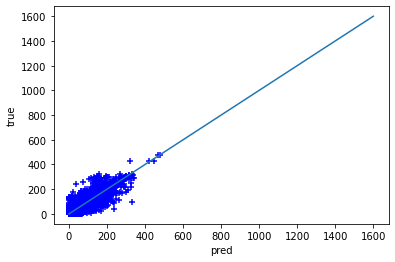

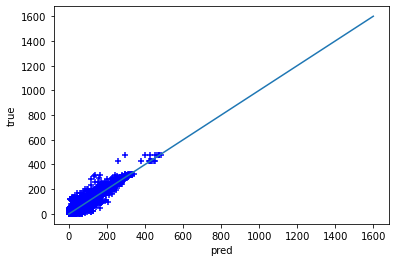

In [24]:

N_EPOCHS_3 = 1200

train_MSEloss_3=[]
test_MSEloss_3=[]

best_test_loss_3 = 1000000

for epoch in range(1, N_EPOCHS_3+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_3.train()
    for i, (hist, target) in enumerate(trainloader_3, 1):   
        hist = hist.float()
        output = Seq2Seq_model_3(hist) 
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1)
        loss = criterion_3(output, target)
        optimizer_3.zero_grad()
        loss.backward()
        optimizer_3.step()
        scheduler_3.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_3_tensor,Y_train_3_tensor,Seq2Seq_model_3,criterion_3)
        train_MSEloss_3.append(train_MSE)
        
        _,_,test_MSE,test_R2 = evaluate_model(X3fold_tensor,Y3fold_tensor,Seq2Seq_model_3,criterion_3)
        test_MSEloss_3.append(test_MSE)

        if test_MSE < best_test_loss_3:
            best_test_loss_3 = test_MSE
            torch.save(Seq2Seq_model_3.state_dict(),'Prediction\best_model_3fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_3fold = Seq2Seq(encoder_3, decoder_cell_3,pre_len=12,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_3fold.load_state_dict(torch.load('Prediction\best_model_3fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_3fold,test_pred_3fold,test_MSE_3fold,test_R2_3fold = evaluate_model(X3fold_tensor,Y3fold_tensor,\
                                                                                  best_Seq2Seq_model_3fold,criterion_3)
    
    print(f'Test 3 fold MSE: {test_MSE_3fold}')
    print(f'Test 3 fold R2: {test_R2_3fold}')
    plt.figure(3)
    plt.scatter(test_pred_3fold,test_true_3fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_3fold,train_pred_3fold,train_MSE_3fold,train_R2_3fold = evaluate_model(X_train_3_tensor,Y_train_3_tensor,\
                                                                                      best_Seq2Seq_model_3fold,criterion_3)
    
    print(f'train 3 fold MSE: {train_MSE_3fold}')
    print(f'train 3 fold R2: {train_R2_3fold}')
    plt.figure(5)
    plt.scatter(train_pred_3fold,train_true_3fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [25]:
e_3 = shap.GradientExplainer(best_Seq2Seq_model_3fold,background)
shap_values_3fold = e_3.shap_values(X3fold_tensor.float())
shap_values_3fold = np.array(shap_values_3fold)  

np.save('Explanation\shap_values_3fold.npy',shap_values_3fold)

# scale the shap values
for i in range(shap_values_3fold.shape[0]):   
    for j in range(shap_values_3fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_3fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_3fold[i,j]

Gather the test results of the three folds

In [26]:
Y_sample_new = np.zeros([len(Y_sample),pred_len*2,1])
for i in range(len(test_true_1fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_1fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_1fold[i]   
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_1fold[i] 

for i in range(len(test_true_2fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_2fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_2fold[i]   
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_2fold[i] 
    
for i in range(len(test_true_3fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_3fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_3fold[i]
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_3fold[i] 
    
Y_sample_new = Y_sample_new.squeeze(2)    

In [27]:
first_graph_data = np.zeros([len(Y_sample_new)-12,pred_len+1])
for i in range(len(Y_sample_new)-12):  
    first_graph_data[i,0] = Y_sample_new[i+1,11]
    for j in range(1,13):
        first_graph_data[i,j] = Y_sample_new[i+13-j,11+j]
first_graph_data_all = first_graph_data[0:-1]

In [28]:
sec_graph_data = first_graph_data_all #shape:[1164,13]
sec_matrix = np.zeros([12,12])
for i in range(12):
    data_4_i = sec_graph_data[i::12,:]
    for j in range(12): 
        true = data_4_i[:,0]
        pred_ahead_j = data_4_i[:,j+1]
        sec_matrix[i,j] = r2_score(true,pred_ahead_j) 
#sec_matrix can be used to plot Fig.12, i.e., R2 of rainfall prediction in different calendar months with different lead months#

Output the prediction results on the test sets of the three folds

In [29]:
pd.DataFrame(data=sec_matrix).to_csv('Prediction\sec_matrix.csv')
pd.DataFrame(data=test_true_1fold.reshape(-1,)).to_csv('Prediction\test_true_1fold.csv')
pd.DataFrame(data=test_pred_1fold.reshape(-1,)).to_csv('Prediction\test_pred_1fold.csv')
pd.DataFrame(data=test_true_2fold.reshape(-1,)).to_csv('Prediction\test_true_2fold.csv')
pd.DataFrame(data=test_pred_2fold.reshape(-1,)).to_csv('Prediction\test_pred_2fold.csv')
pd.DataFrame(data=test_true_3fold.reshape(-1,)).to_csv('Prediction\test_true_3fold.csv')
pd.DataFrame(data=test_pred_3fold.reshape(-1,)).to_csv('Prediction\test_pred_3fold.csv')

Gather the explanation results on the test sets of the three folds

In [30]:
shap_values = SHAP_VALUE.transpose((0,1,3,2))  
np.save('Explanation\SHAP_VALUE.npy',SHAP_VALUE)
np.save('Explanation\shap_values.npy',shap_values)

In [31]:
shap_values.shape

(12, 1177, 13, 12)

In [32]:
def shap_for_month(mon,lt): #mon: 1~12 representing Jan to Dec，lt：1~12 representing lead month
    
    lt = lt - 1 
    feat_index_tab = []
    feat_x_tab = []

    feat_name = ['mon_rain_sum','max_temp_mean','min_temp_mean','radiation_mean','rh_tmax_mean','rh_tmin_mean','SOI','NINO 12',\
                 'NINO 3','NINO 3.4','NINO 4','DMI','PDO']
    feat_x_name = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13']
    minus_time = [lt+12,lt+11,lt+10,lt+9,lt+8,lt+7,lt+6,lt+5,lt+4,lt+3,lt+2,lt+1]
    t_minus_time = ['t-'+str(k) for k in minus_time]
    
    for i in range(feat_num): 
        for j in range(use_len): 
            feat_index_tab.append(feat_name[i]+'_'+t_minus_time[j])
            feat_x_tab.append(feat_x_name[i]+'_'+t_minus_time[j])
            
    shap_lt = shap_values[lt] #shap_lt shape: 1177,13,12
    if lt <= mon-1:
        begin = mon-lt-1 
        mon_y_rain = data_np[mon+11::12,0]
    else:
        begin = mon-lt+11
        mon_y_rain = data_np[mon+23::12,0]
        
    shap_lt_mon = shap_lt[begin::12]  #shap_lt_mon: num_mon,feat_num,use_len
    
    #Calculate the attribution for each feature
    
    feat_sum = np.sum(shap_lt_mon,axis=2)  
    feat_shap_score = np.zeros((feat_num,))
    for i in range(feat_num):
        feat_shap_score[i] = np.mean((abs(feat_sum[:,i])))
    sort_feat_shap = np.sort(feat_shap_score)[::-1]    
    sort_feat_index = feat_shap_score.argsort()[-1::-1]      
    sort_feat_name = [feat_name[k] for k in sort_feat_index]  
    sort_feat_x_name = [feat_x_name[k] for k in sort_feat_index]  
    feat_importance = pd.DataFrame(data=[sort_feat_name,sort_feat_x_name,sort_feat_shap,sort_feat_index],index=\
                 ['sort_feat_name','sort_feat_x_name','sort_feat_shap','sort_feat_index']).transpose()
    
    #Calculate the attribution for each time step
    
    time_sum = np.sum(shap_lt_mon,axis=1)  
    time_shap_score = np.zeros((use_len,))
    for i in range(use_len):
        time_shap_score[i] = np.mean((abs(time_sum[:,i])))
    sort_time_shap = np.sort(time_shap_score)[::-1]    
    sort_time_index = time_shap_score.argsort()[-1::-1]      
    sort_time_name = [t_minus_time[k] for k in sort_time_index]  
    time_importance = pd.DataFrame(data=[sort_time_name,sort_time_shap,sort_time_index],index=\
                 ['sort_time_name','sort_time_shap','sort_time_index']).transpose()
    
    shap_lt_mon_resha = shap_lt_mon.reshape(-1,feat_num*use_len)

    cores_feat = np.zeros(shap_lt_mon_resha.shape)
    for i in range(cores_feat.shape[0]):   
        for j in range(feat_num):          
            cores_feat[i,j*12:(j+1)*12] = data_np[begin+12*i:begin+12+12*i,j]           
            
            
    shap_score = np.zeros((feat_num*use_len,))
    for i in range(feat_num*use_len):
        shap_score[i] = np.mean((abs(shap_lt_mon_resha[:,i])))
    sort_shap_score = np.sort(shap_score)[::-1]    
    sort_shap_index = shap_score.argsort()
    sort_shap_index = sort_shap_index[-1::-1]      
    sort_shap_feat_name = [feat_index_tab[k] for k in sort_shap_index]  
    sort_shap_x_name = [feat_x_tab[k] for k in sort_shap_index]  
    
    top = 20
    sort_shap_allpoint = np.zeros([shap_lt_mon.shape[0],top])
    sort_shap_allfeat = np.zeros([shap_lt_mon.shape[0],top])

    for i in range(top):  
        
        sort_shap_allpoint[:,i] = shap_lt_mon_resha[:,sort_shap_index[i]]      #1164,322
        sort_shap_allfeat[:,i] = cores_feat[:,sort_shap_index[i]]       #1164,322
    
    sort_shap_feat_scaler = preprocessing.MinMaxScaler()
    sort_shap_allfeat_scale = sort_shap_feat_scaler.fit_transform(sort_shap_allfeat)
    
    feat_time_importance = pd.DataFrame(data=[sort_shap_score,sort_shap_feat_name,sort_shap_x_name],index=\
                 ['sort_shap_score','sort_shap_feat_name','sort_shap_x_name']).transpose()
    
    return feat_time_importance,sort_shap_allpoint,sort_shap_allfeat_scale,sort_shap_allfeat,mon_y_rain,\
            feat_importance,time_importance 

Output the explanation results for June rainfall in Darwin (lead month = 7)

In [33]:
feat_time_importance2,sort_shap_allpoint2,sort_shap_allfeat_scale2,\
 sort_shap_allfeat2,mon_y_rain2,feat_importance2,time_importance2 = shap_for_month(6,7)

In [34]:
feat_time_importance1.to_csv(r'Explanation\feat_time_importance1.csv')
pd.DataFrame(data=sort_shap_allpoint1).to_csv(r'Explanation\sort_shap_allpoint1.csv')
pd.DataFrame(data=sort_shap_allfeat_scale1).to_csv(r'Explanation\sort_shap_allfeat_scale1.csv')
pd.DataFrame(data=sort_shap_allfeat1).to_csv(r'Explanation\sort_shap_allfeat1.csv')
pd.DataFrame(data=mon_y_rain1).to_csv(r'Explanation\mon_y_rain1.csv')
feat_importance1.to_csv(r'Explanation\feat_importance1.csv')
time_importance1.to_csv(r'Explanation\time_importance1.csv')